In [1]:
import requests
import json
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn.metrics as skm
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KDTree
from sklearn.decomposition import PCA
import sklearn.feature_extraction.text as text
from sklearn.cluster import MiniBatchKMeans
import umap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_lfw_people
from matplotlib import offsetbox
from sklearn.manifold import Isomap
import gensim.downloader as model_api

# 1. App Review NLP work

This question uses the Apple App review dataset that you generated in the "Pulling online data" workshop. Your dataset should have at least 3-5 different applications, with data from a few countries.

**1.1** Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.

**1.2** Now use a sentence embedding using on of the `gensim` pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale targer using all unsupervised methods you want.

**1.3** Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best **regression** model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)

**1.4** Do the same as in 1.3, but use a classification model. Are classification models better or worse to predict a 5-point rating scale? Explain in a few paragraphs and justify with metrics.


In [2]:
df_reviews = pd.DataFrame(columns = ['app', 'title', 'author', 'rating', 'review', 'version'])

countries = ["ca", "us", "gb", "au", "ie", "nz"]
apps = [553834731, 547702041, 284882215, 333903271]

for app in apps:
    for country in countries:
        for page in range(1, 10):
            url = "https://itunes.apple.com/%s/rss/customerreviews/id=%d/page=%d/sortby=mostrecent/json" % (country, app, page)
            page = requests.get(url)
            site = json.loads(page.content)
            data = site.get("feed").get("entry")
            if data == None:
                continue

            for i in range(0, len(data)):
                if data[i].get('im:name'): continue

                title = data[i].get('title').get('label')
                author = data[i].get('author').get('name').get('label')
                rating = data[i].get('im:rating').get('label')
                review = data[i].get('content').get('label')
                version = data[i].get('im:version').get('label')
                new_row = {'app':app, 'title':title, 'author':author, 'rating':rating, 'review':review, 'version':version}
                df_reviews = df_reviews.append(new_row, ignore_index=True)
                continue

df_reviews.loc[df_reviews.app == 553834731, 'app'] = "Candy Crush"
df_reviews.loc[df_reviews.app == 547702041, 'app'] = "Tinder"
df_reviews.loc[df_reviews.app == 284882215, 'app'] = "Facebook"
df_reviews.loc[df_reviews.app == 333903271, 'app'] = "Twitter"
df_reviews.rating = df_reviews.rating.astype(int)
df_reviews

,app,title,author,rating,review,version
0,Candy Crush,Not working,28Newt,1,This app used to be great but it won’t open an...,1.197.0.1
1,Candy Crush,Fav game,yada cutesy mate,5,I ove it,1.197.0.1
2,Candy Crush,I like,Cadenlawn,3,I like the game but my time is precious to me ...,1.197.0.1
3,Candy Crush,Reward calendar freezes the app,Bird & The Bee,4,This has been happening all of a sudden every ...,1.197.0.1
4,Candy Crush,Awesome game!,dead bon,5,"I love this game, this is the best game ever. ...",1.197.0.1
...,...,...,...,...,...,...
10795,Twitter,"Not bad, but has its problems",Ledestin,4,"Nice overall, but:\n1. Will reset position som...",6.1.1
10796,Twitter,تويتر,معاذ 1994,1,اصدار سيء جداً,6.1
10797,Twitter,Tweet this,Taknz123,5,"Twitter app works a charm on 4-5s I love it, i...",6.1
10798,Twitter,Good,AboRanim,5,Good,6.1


In [3]:
COMPRESSED_SIZE = 1000
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df_reviews['review'])
wordLabels = vectorizer.get_feature_names()

tf = text.TfidfVectorizer()
X = tf.fit_transform(df_reviews['review'])

Xd = X.toarray()
Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

Xc = (X.T @ X).todense()

my_embeddings = PCA(COMPRESSED_SIZE).fit(Xc).components_.T
my_embeddings = sklearn.preprocessing.normalize(my_embeddings)
tree = KDTree(my_embeddings)
evalWord = 'fun'
k = 10000

dist, ind = tree.query([my_embeddings[wordLabels.index(evalWord)]], k=k)

for i in range(k):
    print(wordLabels[ind[0][i]], ":  ", dist[0][i])

fun :   0.0
dmontez :   0.7433793342285716
creative :   1.266103558703711
rlly :   1.326823111630003
aswome :   1.3318929372621016
wimsical :   1.3461866797610924
antidote :   1.3461866797610924
brilliantly :   1.3560067226927566
programs :   1.3631672862207047
66 :   1.3671240537422689
pre :   1.3707801615624284
intertaing :   1.3765837312243858
charming :   1.3781632512367215
cud :   1.3781632512367215
fist :   1.378732378956548
craziness :   1.3803683103745168
sleepypawz :   1.384172613446019
prepare :   1.3861301682618794
2400 :   1.3867891804295087
manuel :   1.3876658186534834
distraction :   1.3878157961985675
occupy :   1.3879102740703144
packs :   1.3880921847931647
3524 :   1.3895952254187223
solving :   1.3896734567410811
shifted :   1.3900115076779296
scenario :   1.3900115076779296
squeeze :   1.3900115076779296
carrot :   1.3900115076779296
attainable :   1.3900115076779296
donkey :   1.3900115076779296
albeit :   1.39001150767793
ransom :   1.3903714167225953
aunt :   1.

languages :   1.4126201654495338
checked :   1.4126214265292256
potus :   1.4126219448163604
alert :   1.4126220553706483
unhappy :   1.4126238390280406
forgive :   1.4126286538034412
fuvking :   1.4126286928424456
vision :   1.4126293695713967
typos :   1.4126305758785167
car :   1.4126308348706746
sustain :   1.412632289998918
origin :   1.4126322899989185
yous :   1.412634344744341
journalists :   1.4126356710627308
plugging :   1.412637297668373
plenty :   1.4126376686606077
solution :   1.4126399904854348
outlandish :   1.4126400693856322
snowflakesmasha87 :   1.4126404887789266
tolerated :   1.4126406236194833
irritation :   1.4126409205106196
crops :   1.412641284980239
wannabes :   1.412641967948045
ripped :   1.4126420185774802
infiltrate :   1.4126438255690386
fitness :   1.4126456979658863
creeping :   1.4126456979658863
financials :   1.4126456979658863
colour :   1.4126462738441852
relations :   1.412648233721328
angrier :   1.4126482337213284
550 :   1.4126482337213289
as

thrive :   1.4133908686818601
politely :   1.4133908686818601
rogues :   1.4133908686818601
owned :   1.4133912313627015
dreadful :   1.4133914590457708
dot :   1.4133920073902178
twiitter :   1.4133938617155102
eviscerated :   1.4133938617155102
commentary :   1.4133939088449525
chur :   1.4133950614970627
problème :   1.4133959673785659
chatting :   1.413397057983441
efforts :   1.4133974064988732
factchecking :   1.4133990199711002
comprehensive :   1.4134004703321204
confounding :   1.4134004703321204
equipment :   1.4134004703321204
gateway :   1.4134004703321204
circumnavigate :   1.4134004703321204
sensory :   1.4134004703321204
explorative :   1.4134004703321204
mysef :   1.4134006040188591
injured :   1.4134008030928067
trustable :   1.4134008648637144
overall :   1.413402099993078
anger :   1.4134023982303252
unopened :   1.4134025473650595
blessing :   1.4134055380722994
ipad2 :   1.4134066036626869
preface :   1.4134066253408841
plot :   1.4134069183080935
az :   1.41340737

étais :   1.4138711739471668
hunted :   1.4138719344045017
mob :   1.4138719344045017
finest :   1.413873911481218
ask :   1.413874600923112
unbelievably :   1.4138747706487453
crowns :   1.4138748983405056
tactfully :   1.4138751344265656
suffering :   1.4138751344265656
redownloading :   1.4138760000662596
473 :   1.413876773862016
kindergarten :   1.4138767738620166
pornography :   1.413877507767142
typing :   1.4138776196427516
platforms :   1.4138777232901547
husband :   1.413877832486679
second :   1.4138778824711966
souvent :   1.4138779935875632
costing :   1.4138781761915198
budget :   1.4138792563770513
oz :   1.4138805630525575
alter :   1.4138805696844148
worships :   1.413880569684415
unforgivable :   1.4138805768987326
refusal :   1.4138806981598457
gop :   1.4138808321472218
prioritises :   1.4138821269370494
etw :   1.4138821953041727
managers :   1.413882497651802
ss :   1.413883823932719
processes :   1.4138838801339333
jumpy :   1.4138838801339333
manager :   1.41388

wonder :   1.4141872209536404
zuc :   1.4141872584701427
stupid :   1.4141875277831435
ignoring :   1.4141877341645177
feel :   1.4141877390706947
slowest :   1.414187899861597
adi :   1.4141884471083273
sizin :   1.4141884471083277
hemde :   1.4141884471083277
silecem :   1.4141884471083277
sistemm :   1.4141884471083277
canlar :   1.4141884471083277
hem :   1.4141884471083277
ettiniz :   1.4141884471083277
insani :   1.4141884471083277
seviye :   1.4141884471083277
sinir :   1.4141884471083277
siz :   1.4141884471083277
zor :   1.4141884471083277
gecinn :   1.4141884471083277
kolaysa :   1.4141884471083277
yuzunuzde :   1.4141884471083277
iyimisiniz :   1.4141884471083277
bir :   1.4141884471083277
oyunu :   1.4141884471083277
wish :   1.4141884955634818
ipad :   1.4141887618492912
tom :   1.4141891722413902
some :   1.414189177111897
backup :   1.4141891921773315
censored :   1.4141892298200966
you :   1.4141896667765803
subscription :   1.4141897472942873
restricted :   1.414189773

included :   1.4144468861147963
39 :   1.4144473149599834
agencies :   1.4144476631325158
filters :   1.4144476707539226
filtered :   1.4144478832106318
cancer :   1.4144479546738329
agenda :   1.4144486303490174
stan :   1.4144491672323234
moyen :   1.4144493794797057
publicity :   1.4144498419052869
invention :   1.4144504749837425
continuesly :   1.4144511241000377
sesspool :   1.4144512044258846
abusers :   1.4144512845374182
fortunately :   1.4144513002983141
developments :   1.4144513002983141
algerians :   1.414451399500288
circled :   1.4144513995002892
flipped :   1.4144513995002892
twitterexposed :   1.4144514107799977
okeefe :   1.4144514107799977
improved :   1.4144518537271482
cancels :   1.4144519277262733
ppl :   1.4144520047924527
trust :   1.4144520282124036
memes :   1.4144520691851519
useful :   1.4144525749566126
sans :   1.4144531714998358
clip :   1.414453269041106
professionals :   1.414453399136852
pm :   1.4144539055297618
scrapes :   1.414453995800568
unistall

pond :   1.4147301566946897
haiku :   1.4147301566946897
pebble :   1.4147301566946897
paired :   1.4147301566946897
history :   1.414730899968116
eliminating :   1.414731068667516
disposal :   1.4147311366271422
override :   1.4147321828319164
strain :   1.4147329872788237
identity :   1.4147329962202027
mixed :   1.414734188958326
defending :   1.4147348609290245
todo :   1.4147349832036031
platinum :   1.4147353340014548
verifying :   1.414735684105568
rules :   1.4147357985351778
deny :   1.4147358495254267
gather :   1.4147359636945311
lag :   1.4147367053260116
steering :   1.4147368697555538
externally :   1.4147368697555538
overriding :   1.4147368697555538
abusing :   1.414737033755141
champ :   1.4147372899838464
permission :   1.4147373718066425
ridden :   1.4147377737782254
living :   1.4147378346328576
driving :   1.414737941652307
60km :   1.414738019069901
tear :   1.4147384666157474
sync :   1.4147389741362537
punch :   1.4147393375367048
tops :   1.4147401792136718
hat

disrupted :   1.4151017236895245
closures :   1.4151017236895245
amplified :   1.4151017236895256
boom :   1.415102324085184
laggiest :   1.41510270096421
tao :   1.4151032960663543
zur :   1.4151032960663543
tụi :   1.4151032960663543
mack :   1.4151032960663543
dcm :   1.4151032960663543
funeral :   1.4151038251626757
decentralised :   1.4151043850633278
blockchain :   1.4151043850633278
communities :   1.4151045522016812
__ :   1.415105152054415
unappealing :   1.4151052347483477
earphones :   1.4151052347483477
tldr :   1.4151054438630324
yours :   1.4151057513788217
ukrainian :   1.4151060580638346
nam :   1.4151067521497875
việt :   1.4151067521497875
applies :   1.4151071154600934
bullet :   1.41510726195197
officially :   1.4151073107371617
layer :   1.415107621712011
ripping :   1.415107836953186
hồ :   1.4151082242670343
penpals :   1.4151090077389585
cancel :   1.4151092547432649
problematic :   1.4151098407394598
1052 :   1.415110211270092
firecrackers :   1.415110211270095

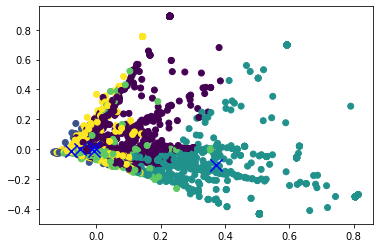

In [4]:
vec = TfidfVectorizer(stop_words="english")
vec.fit(df_reviews.review.values)
features = vec.transform(df_reviews.review.values)

cls = MiniBatchKMeans(n_clusters=5, random_state=True)
cls.fit(features)

cls.predict(features)

pca = PCA(n_components=5, random_state=True)
reduced_features = pca.fit_transform(features.toarray())

reduced_cluster_centers = pca.transform(cls.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [5]:
print(homogeneity_score(df_reviews.review, cls.predict(features)))
print(silhouette_score(features, labels=cls.predict(features)))

0.12362031576579009
0.0088812198619382


In [6]:
words = df_reviews.review.str.split()
words = pd.DataFrame(words.tolist())
replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))
def replacer(text):
    return rep[re.escape(text.group(0))]

words = df_reviews.review.str.replace(pattern, replacer).str.lower().str.split()
words = pd.DataFrame(words.tolist())
words

,0,1,2,3,4,5,6,7,8,9,...,623,624,625,626,627,628,629,630,631,632
0,this,app,used,to,be,great,but,it,won’t,open,...,None,None,None,None,None,None,None,None,None,None
1,i,ove,it,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,i,like,the,game,but,my,time,is,precious,to,...,None,None,None,None,None,None,None,None,None,None
3,this,has,been,happening,all,of,a,sudden,every,time,...,None,None,None,None,None,None,None,None,None,None
4,i,love,this,game,this,is,the,best,game,ever,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10795,nice,overall,but,1,will,reset,position,sometime,2,will,...,None,None,None,None,None,None,None,None,None,None
10796,اصدار,سيء,جداً,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
10797,twitter,app,works,a,charm,on,4,5s,i,love,...,None,None,None,None,None,None,None,None,None,None
10798,good,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [7]:
model = model_api.load("glove-wiki-gigaword-300")

word_vectors = model.wv

def soft_get(w):
    try:
        return word_vectors[w]
    except KeyError:
        return np.zeros(word_vectors.vector_size)

def map_vectors(row):
    try:
        return np.sum(
            row.loc[words.iloc[0].notna()].apply(soft_get)
        )
    except:
        return np.zeros(word_vectors.vector_size)

emb = pd.DataFrame(words.apply(map_vectors, axis=1).tolist())
emb

<ipython-input-7-e5b5b2e3b9e6>:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  word_vectors = model.wv


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-5.044251,3.611061,-2.955918,-5.121329,-0.454621,2.874414,-0.476455,0.548995,3.650259,-64.327019,...,-1.118603,-11.081712,-0.135671,4.265076,3.694871,6.325059,1.519332,-10.029046,-2.147825,1.022005
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10795,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10797,-6.342651,2.585120,-6.112706,-6.384397,-4.622836,-0.483030,-1.490743,1.589856,2.405834,-66.683119,...,-1.824545,-7.572852,-3.785943,-1.401613,5.531813,-1.392185,6.938995,-9.419336,-0.811585,4.949418
10798,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
X = emb
X = sm.add_constant(X)
y = df_reviews.rating

model = sm.OLS(y, X)
res = model.fit(cov_type="HC1")
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     13.29
Date:                Sun, 07 Mar 2021   Prob (F-statistic):               0.00
Time:                        11:11:39   Log-Likelihood:                -20459.
No. Observations:               10800   AIC:                         4.152e+04
Df Residuals:                   10499   BIC:                         4.371e+04
Df Model:                         300                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5267      0.020    127.524      0.000       2.488       2.565
0              0.0019      0.051      0.038      0.970      -0.098       0.102
1              0.1436      0.058      2.495      0.013       0.031       0.256
2              0.0133      0.058      0.230      0.818      -0.100       0.127
3              0.0598      0.054      1.111      0.267      -0.046       0.165
4             -0.0944      0.053     -1.765      0.078      -0.199       0.010
5             -0.0411      0.053     -0.780      0.435      -0.144       0.062
6              0.0721      0.046      1.561      0.119      -0.018       0.163
7             -0.0458      0.052     -0.876      0.381      -0.148       0.057
8             -0.0559      0.054     -1.035      0.301      -0.162       0.050
9             -0.0777      0.046     -1.681      0.093      -0.168       0.013
10             0.0474      0.063      0.749      0.454      -0.077       0.172
11            -0.0120      0.050     -0.243      0.808      -0.109       0.085
12             0.0049      0.051      0.096      0.924      -0.096       0.106
13            -0.0714      0.059     -1.216      0.224      -0.186       0.044
14            -0.0690      0.058     -1.199      0.230      -0.182       0.044
15             0.0429      0.045      0.948      0.343      -0.046       0.132
16            -0.0034      0.054     -0.063      0.950      -0.109       0.102
17             0.0221      0.051      0.435      0.663      -0.077       0.121
18            -0.0089      0.059     -0.152      0.879      -0.124       0.106
19            -0.0628      0.051     -1.237      0.216      -0.162       0.037
20             0.0340      0.056      0.611      0.541      -0.075       0.143
21             0.0545      0.055      0.989      0.323      -0.053       0.162
22             0.0577      0.061      0.949      0.343      -0.061       0.177
23             0.0086      0.057      0.152      0.879      -0.102       0.119
24             0.0539      0.049      1.090      0.276      -0.043       0.151
25            -0.1206      0.050     -2.391      0.017      -0.220      -0.022
26            -0.0669      0.060     -1.118      0.264      -0.184       0.050
27            -0.0658      0.050     -1.312      0.189      -0.164       0.032
28            -0.0343      0.052     -0.660      0.509      -0.136       0.068
29            -0.0654      0.049     -1.343      0.179      -0.161       0.030
30            -0.0217      0.042     -0.514      0.607      -0.104       0.061
31             0.1321      0.060      2.196      0.028       0.014       0.250
32            -0.0369      0.054     -0.678      0.498      -0.143       0.070
33            -0.0088      0.055     -0.160      0.873      -0.116       0.099
34            -0.0339      0.063     -0.541      0.588      -0.157       0.089
35

In [9]:
pred = res.predict()

print("Mean absolute error =", round(skm.mean_absolute_error(y, pred), 3)) 
print("Mean squared error =", round(skm.mean_squared_error(y, pred), 3)) 
print("Median absolute error =", round(skm.median_absolute_error(y, pred), 3)) 
print("Explain variance score =", round(skm.explained_variance_score(y, pred), 3)) 
print("R2 score =", round(skm.r2_score(y, pred), 3))

Mean absolute error = 1.432
Mean squared error = 2.588
Median absolute error = 1.527
Explain variance score = 0.09
R2 score = 0.09


In [10]:
LogReg = LogisticRegression(random_state=0).fit(X, y)
LogReg.score(X, y)

C:\Users\gaia_\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5673148148148148

<font color=blue>OLS minimizes the squares within the data, doing so maximizes any errors and gets worse with larger errors. The word scores are rather arbitrarily assigned by the computer/model and tend to have large errors. These errors are even larger considering how the model does not recognize certain words. 
    
In addition, another possibility for errors comes from the fact that these are all "internet" reviews so some words don't even exist or certain slang words (e.g. "sick" or "wicked") might be used in a different context from what they normally are. Due to that, LogReg will provide a better score as it does not penalize these errors as heavily.

This is very evident when comparing the OLS score with the LogReg score. OLS has a near 0 R-squared score while LogReg gives a somewhat higher and reasonable score.</font>

## 2. Face data

Here let's apply manifold learning on some face data.

Use the following code:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
```

To get the `faces` dataset.

Use dimensionality reduction so that the darkness of the image is sorted in the first dimension as seen in this picture:

![](isofaces.png)

Then produce a picture similar to this one with your result

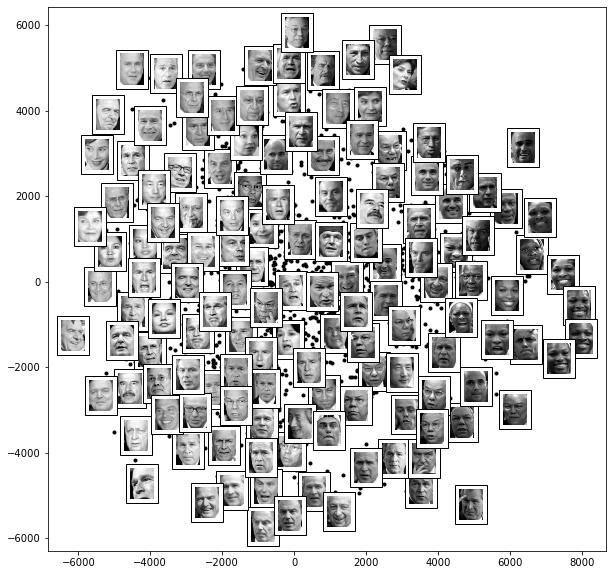

In [11]:
faces = fetch_lfw_people(min_faces_per_person=30)

fig, ax = plt.subplots(figsize=(10, 10))

data = faces.data

model=Isomap(n_components=2)

images=faces.images[:, ::2, ::2]

ax = ax or plt.gca()

proj = model.fit_transform(data)
ax.plot(proj[:, 0], proj[:, 1], '.k')

if images is not None:
    min_dist_2 = (0.05 * max(proj.max(0) - proj.min(0))) ** 2
    shown_images = np.array([2 * proj.max(0)])
    for i in range(data.shape[0]):
        dist = np.sum((proj[i] - shown_images) ** 2, 1)
        if np.min(dist) < min_dist_2:
            # don't show points that are too close
            continue
        shown_images = np.vstack([shown_images, proj[i]])
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(images[i], cmap='gray'),
                                  proj[i])
        ax.add_artist(imagebox)